In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./"

from misc import h5file
import pickle
with open("../Datasets/nv_desc.pkl", "rb") as desc_fp:
    description = pickle.load(desc_fp)
ground_indices = (3, 5, 16, 24)
ground_coeffs = np.array([0.01, 0.01, -1, -1])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
Xr, wtr = h5file("../Datasets/nv_originalV2_noiselv2.h5")
# Xr, wtr = h5file("../Datasets/nv_newcut_original_noiselv2.h5")
Xr = Xr.real[:, 1:]
wtr = wtr.real
description = description[1:]

['X', 'wt']


In [3]:
combine = False
if not combine:
    newXr = Xr
else:
    # Combine features
    newXr = np.hstack((Xr, Xr[:, 2:3]+Xr[:, 4:5], Xr[:, 15:16]+Xr[:, 23:24]))
    description.append(f"{description[2]}+{description[4]}")
    description.append(f"{description[15]}+{description[23]}")
    newXr = np.delete(newXr, [2, 4, 15, 23], axis=1)
    print(description.pop(2))
    print(description.pop(4-1))
    print(description.pop(15-2))
    print(description.pop(23-3))

In [4]:
lam = 10**-6
d_tol = 5
c = TrainSTRidge(newXr,wtr,lam,d_tol)
print_pde(c, description, ut = 'w_t')

l0_penalty: 1.3911409799391197
w_t = (0.011551 +0.000000i)w_{xx}
    + (0.008421 +0.000000i)w_{yy}
    + (-0.980764 +0.000000i)uw_{x}
    + (-0.971890 +0.000000i)vw_{y}
    + (-0.009184 +0.000000i)uw_{yy}
    + (0.006396 +0.000000i)u^2w_{yy}
   


In [5]:
def ic(effective_indices, dataset, ic_type='bic'):
    s = len(effective_indices)
    XX, yy = dataset
    XX = XX[:, effective_indices]
    abess_model = LinearRegression(support_size=s, ic_type=ic_type, always_select=None)
    abess_model.fit(XX, yy)
    return abess_model.ic_

In [6]:
lrs = []
eff_indices = []
max_complexity = 10
for s in range(1, max_complexity):
    lr = LinearRegression(support_size=s, ic_type='bic', always_select=None)
    lr.fit(newXr, wtr)
    lrs.append(lr)
    eff_indices.append(nonz(lr.coef_))
    print(nonz(lr.coef_))
abess_feature_hierarchy = set(eff_indices)

(0,)
(0, 23)
(4, 15, 23)
(2, 4, 15, 23)
(2, 4, 15, 23, 58)
(2, 4, 15, 23, 27, 58)
(0, 2, 4, 15, 20, 23, 58)
(0, 2, 4, 15, 20, 23, 53, 58)
(0, 2, 4, 15, 20, 23, 27, 53, 58)


In [7]:
nor_axis = 0
if nor_axis is not None: Xfrols = normalize(newXr, axis=nor_axis)
else: Xfrols = newXr.copy()
frols_coeffs,selected_inds_list,_,_,_ = frols(wtr, Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0,),
 (0, 2, 4, 5, 15, 20, 23, 27, 53, 58),
 (0, 2, 4, 15, 20, 23),
 (0, 2, 4, 15, 20, 23, 27, 53, 58),
 (0, 2, 4, 15, 20, 23, 53),
 (0, 2, 4, 15, 20, 23, 53, 58),
 (0, 4, 15, 20, 23),
 (0, 15, 20),
 (0, 15, 20, 23),
 (0, 20)}

In [8]:
feature_hierarchy = abess_feature_hierarchy.union(selected_inds_list)

In [9]:
ic_type = 'bic' # bic, aic, aicc, hqic
br1 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='rfe', ic_type=ic_type, verbose=True)
br2 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='k best', ic_type=ic_type, verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(2, 4, 15, 23, 58)
(2, 4, 15, 23)
(4, 15, 23)
(15, 23)
(15,)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 53)
(2, 4, 15, 20, 23, 53)
(2, 4, 15, 23, 53)
(2, 4, 15, 23)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 53, 58)
(0, 2, 4, 15, 20, 23, 53)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 27, 53, 58)
(2, 4, 15, 20, 23, 27, 53, 58)
(2, 4, 15, 20, 23, 27, 53)
(2, 4, 15, 20, 23, 53)
--------------------------------------------------
(0, 15, 20)
(0, 20)
(0,)
--------------------------------------------------
(2, 4, 15, 23, 27, 58)
(2, 4, 15, 23, 58)
--------------------------------------------------
(0, 15, 20, 23)
(15, 20, 23)
(15, 23)
--------------------------------------------------
(0, 23)
(0,)
--------------------------------------------------
(0, 20)
--------------------------------------------------
(0, 2, 4, 15, 20, 23, 58)
(0, 2, 4, 15, 23, 58)
(2, 4, 15, 23, 58)
-----------

{1: ((0,), 273464.4246791447), 2: ((15, 23), -231816.91759647388), 3: ((4, 15, 23), -354759.44659437705), 4: ((2, 4, 15, 23), -411415.3523686379), 5: ((2, 4, 15, 23, 58), -424707.35307596525), 6: ((2, 4, 15, 20, 23, 53), -431197.6667018902), 7: ((2, 4, 15, 20, 23, 27, 53), -442226.8161312662), 8: ((2, 4, 15, 20, 23, 27, 53, 58), -449815.3193933275), 9: ((2, 4, 5, 15, 20, 23, 27, 53, 58), -454325.76663038024), 10: ((0, 2, 4, 5, 15, 20, 23, 27, 53, 58), -455643.04169511213)}

In [10]:
complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(0,) 273464.4246791447
(15, 23) -231816.91759647388
(4, 15, 23) -354759.44659437705
(2, 4, 15, 23) -411415.3523686379
(2, 4, 15, 23, 58) -424707.35307596525
(2, 4, 15, 20, 23, 53) -431197.6667018902
(2, 4, 15, 20, 23, 27, 53) -442226.8161312662
(2, 4, 15, 20, 23, 27, 53, 58) -449815.3193933275
(2, 4, 5, 15, 20, 23, 27, 53, 58) -454325.76663038024
(0, 2, 4, 5, 15, 20, 23, 27, 53, 58) -455643.04169511213


#### Model selection

In [11]:
from UBIC import UBICs, baye_uncertainties, log_like_value

In [12]:
best_subsets = [br_u.track[com][0] for com in complexities]
n_lams = 3

In [13]:
ics, bc, lam = UBICs(best_subsets, (newXr, wtr), u_type='cv', delta=1.5, n_lams=n_lams)
ics, bc, lam

n_lams = 3
Using OLS's uncertainties
[2.09469851 1.23535638 1.02475071 1.         1.00167896 2.00635582
 3.17990087 3.19383736 4.52924887 6.36578533]
0 ---> 10
1.5 ---> 10
3.0 ---> 5
4.5 ---> 5
6.0 ---> 4
7.5 ---> 4
9.0 ---> 4
[26690833.74931014 15347926.65296439 12568922.8051724  12200122.4012697
 12208004.72006429 24872034.54699043 39661213.05567105 39829385.13400323
 56666467.34981214 79826698.98343161]
The optimal complexity is currently at the support sizes of 4.


([array([ 273490.84204847, -231801.3378529 , -354746.52291213,
         -411402.74083088, -424694.72036389, -431172.36346968,
         -442186.71269139, -449775.04019287, -454268.64583726,
         -455562.75935309]),
  array([ 274299.8152477 , -231324.24284603, -354350.76387766,
         -411016.54052765, -424307.8716442 , -430397.5082423 ,
         -440958.63401124, -448541.5792357 , -452519.44855035,
         -453104.29112819]),
  array([ 299881.79400378, -216237.17402591, -341835.76434261,
         -398803.814615  , -412074.64100282, -405894.4344882 ,
         -402123.37625946, -409536.11893993, -397204.97351394,
         -375360.69966999]),
  array([1108854.99323612,  260857.83284689,   53923.27012439,
          -12603.51138163,  -25225.92131366,  368960.79289223,
          825955.3038938 ,  823924.83823887, 1351992.31340188,
         2083107.52522544]),
  array([26690833.74931014, 15347926.65296439, 12568922.8051724 ,
         12200122.4012697 , 12208004.72006429, 24872034.546990

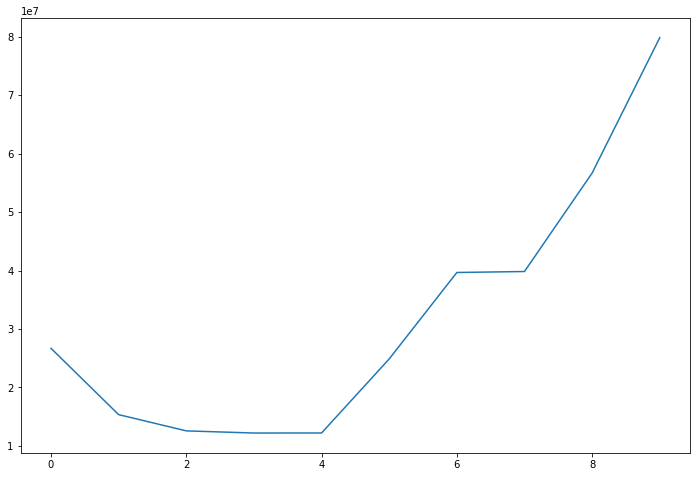

In [14]:
plt.plot(ics[-n_lams]); plt.show()

In [15]:
ics, bc, lam = UBICs(best_subsets, (newXr, wtr), u_type='cv', delta=1.0, n_lams=n_lams)
ics, bc, lam

n_lams = 3
Using OLS's uncertainties
[2.09469851 1.23535638 1.02475071 1.         1.00167896 2.00635582
 3.17990087 3.19383736 4.52924887 6.36578533]
0 ---> 10
1.0 ---> 10
2.0 ---> 9
3.0 ---> 5
4.0 ---> 5
5.0 ---> 5
[ 299881.79400378 -216237.17402591 -341835.76434261 -398803.814615
 -412074.64100282 -405894.4344882  -402123.37625946 -409536.11893993
 -397204.97351394 -375360.69966999]
4 to 5 complexity may not be worthy.
Staying at 4 complexity...
The optimal complexity is currently at the support sizes of 4.


([array([ 273490.84204847, -231801.3378529 , -354746.52291213,
         -411402.74083088, -424694.72036389, -431172.36346968,
         -442186.71269139, -449775.04019287, -454268.64583726,
         -455562.75935309]),
  array([ 273728.59837239, -231661.12016077, -354630.20977186,
         -411289.2369911 , -424581.02595523, -430944.63437975,
         -441825.78173255, -449412.52738879, -453754.55869922,
         -454840.21827486]),
  array([ 276106.16161161, -230258.94323942, -353467.0783692 ,
         -410154.19859327, -423444.08186865, -428667.34348052,
         -438216.47214409, -445787.39934799, -448613.68731874,
         -447614.8074926 ]),
  array([ 299881.79400378, -216237.17402591, -341835.76434261,
         -398803.814615  , -412074.64100282, -405894.4344882 ,
         -402123.37625946, -409536.11893993, -397204.97351394,
         -375360.69966999]),
  array([ 537638.11792545,  -76019.48189087, -225522.62407671,
         -285299.97483225, -298380.23234456, -178165.34456497,
  

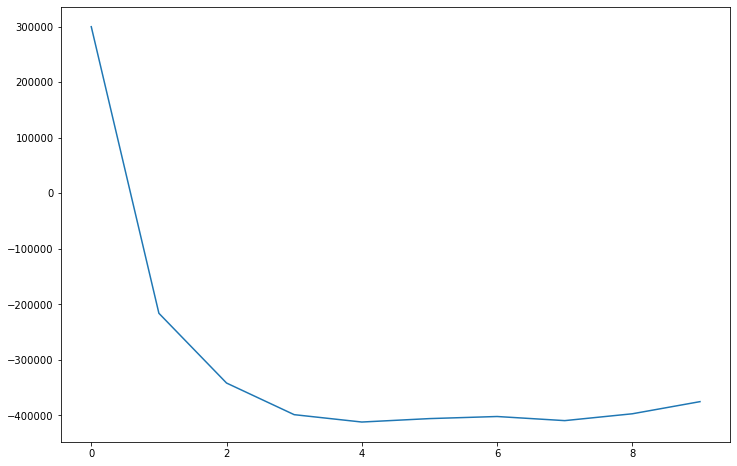

In [16]:
plt.plot(ics[-n_lams]); plt.show()

In [17]:
ics, bc, lam = UBICs(best_subsets, (newXr, wtr), u_type='cv', take_sqrt=True, use_baye=True, delta=(1+1/3), n_lams=n_lams)
ics, bc, lam

n_lams = 3
Using baye_uncertainties
[2.09458473 1.23535876 1.02475245 1.         1.00167332 2.00634903
 3.17988459 3.19380499 4.52919461 6.36568686]
0 ---> 10
1.3333333333333333 ---> 10
2.6666666666666665 ---> 8
4.0 ---> 5
5.333333333333333 ---> 5
6.666666666666666 ---> 4
7.999999999999999 ---> 4
9.333333333333332 ---> 4
[1.22885371e+08 7.20830862e+07 5.96317615e+07 5.81261575e+07
 5.82108177e+07 1.17015605e+08 1.85700499e+08 1.86507777e+08
 2.64673733e+08 3.72176215e+08]
The optimal complexity is currently at the support sizes of 4.


([array([ 273490.84061354, -231801.33782288, -354746.52289022,
         -411402.74083088, -424694.72043505, -431172.36355529,
         -442186.71289676, -449775.04060113, -454268.64652162,
         -455562.76059498]),
  array([ 274033.53873335, -231481.26154962, -354481.01382877,
         -411143.64502433, -424435.19107783, -430652.52693393,
         -441362.81813527, -448947.53912141, -453095.15119216,
         -453913.43782426]),
  array([ 285725.61528884, -224585.42728396, -348760.79450363,
         -405561.59508744, -418843.80057512, -419452.9864318 ,
         -423612.54358428, -431119.56018198, -427812.96072852,
         -418379.85590128]),
  array([ 537623.76858533,  -76019.18169749, -225522.40501701,
         -285299.97483225, -298380.94392947, -178166.20072977,
          -41194.47108202,  -47027.39737927,  116875.32102007,
          347167.95965819]),
  array([ 5964604.96675456,  3124743.55089555,  2429568.20951929,
          2305658.09073988,  2296912.62824784,  5020200.012897

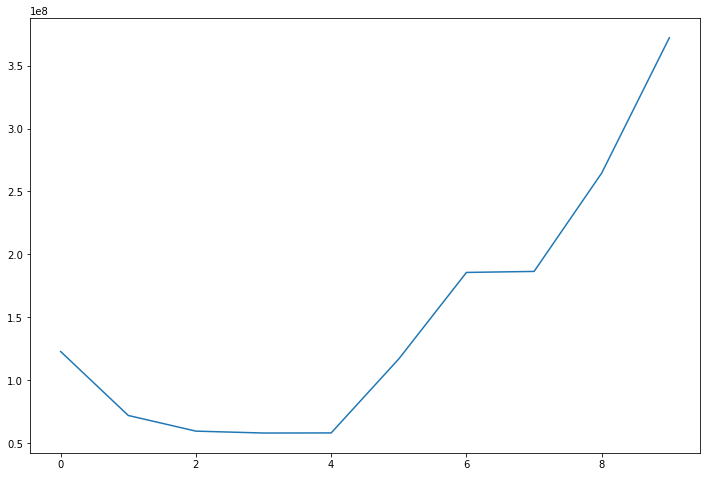

In [18]:
plt.plot(ics[-n_lams]); plt.show()

In [19]:
b_uns = baye_uncertainties(best_subsets, (newXr, wtr), u_type='cv', take_sqrt=True)
lower_bounds = []
for efi in best_subsets:
    com = len(efi)
    w = np.linalg.lstsq(newXr[:, efi], wtr, rcond=None)[0]
    pred = newXr[:, efi]@w
    lower_bound = log_like_value(pred, wtr)/np.log(len(wtr))-com
    lower_bounds.append(lower_bound)
max_lam = max(np.nan_to_num(np.log10(lower_bounds/b_uns)))
delta = np.linspace(0, max_lam, 5)[1]
max_lam

4.2255011471362325

In [20]:
n_lams = 3
ics, bc, lam = UBICs(best_subsets, 
                     (newXr, wtr), 
                     u_type='cv', take_sqrt=True, use_baye=True, 
                     max_lam=max_lam,
                     delta=delta, 
                     n_lams=n_lams)
# ics[-n_lams], bc, lam

n_lams = 3
Using baye_uncertainties
[2.09458473 1.23535876 1.02475245 1.         1.00167332 2.00634903
 3.17988459 3.19380499 4.52919461 6.36568686]
0 ---> 10
1.0563752867840581 ---> 10
2.1127505735681162 ---> 9
3.1691258603521746 ---> 5
4.2255011471362325 ---> 5
[ 312457.89047368 -208819.08001931 -335682.32410605 -392799.02940458
 -406059.87901292 -393846.8250946  -383029.05769523 -390358.4142267
 -370008.81708113 -337137.35926176]
4 to 5 complexity may not be worthy.
Staying at 4 complexity...
The optimal complexity is currently at the support sizes of 4.


In [21]:
lam

3.1691258603521746